# Filmstrip Chart Generator

This notebook generates a filmstrip visualization showing video thumbnails, state sizes, and input events over time.

## Imports

Import required libraries for data processing and visualization.


In [216]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from numpy import arange, array, concatenate
from matplotlib.pyplot import bar, yscale, subplots, tight_layout

## Data Directory

List available data directories.

In [217]:
!ls data/

Album 0            Android for Thesis DSL for Thesis     MS-DOS for Thesis


## Configuration

Set the filepath to the data directory containing the video and state files.

In [218]:
current_filepath = "data/DSL for Thesis/8c239eac-d539-4290-a7da-b6e06930b498"
savestream_filename = current_filepath + "/states.savestream"

## Load State Data

Read and unpack the savestream file containing the state snapshots.

In [219]:
# Read and unpack the savestream file
with open(savestream_filename, 'rb') as f:
    unpacker = msgpack.Unpacker(f, raw=False)
    states = list(unpacker)[0]

print(f"Number of states: {len(states)}")

Number of states: 641


## Calculate State Sizes

Compute the encoded size (in bytes) of each state snapshot.

In [220]:
sizes = [len(msgpack.packb(state)) for state in states]
print(f"Computed sizes for {len(sizes)} states")

Computed sizes for 641 states


## Generate Video Thumbnails

Extract thumbnail frames from the video at 1 frame per second using ffmpeg.

In [221]:
# Create thumbnails directory
video_file = os.path.join(current_filepath, "response.webm")
thumbs_dir = os.path.join(current_filepath, "thumbnails")
os.makedirs(thumbs_dir, exist_ok=True)

# Generate thumbnails at 1fps (one per second) with higher quality
# Using scale filter to maintain quality and png compression level 1 for faster processing
!ffmpeg -i "{video_file}" -vf "fps=1,scale=-1:768" -q:v 1 "{thumbs_dir}/thumb_%04d.png"

ffmpeg version 8.0.1 Copyright (c) 2000-2025 the FFmpeg developers
  built with Apple clang version 17.0.0 (clang-1700.4.4.1)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/8.0.1 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enable-libsoxr --

## Additional Imports

Import additional libraries needed for image processing, file parsing, and event handling.


In [222]:
import msgpack
import os
import json
import glob
import re
from collections import Counter
from PIL import Image

## Visualization Configuration

Configure parameters for the filmstrip visualization, including thumbnail processing and event display settings.


In [297]:
# Thumbnail processing parameters
k = 64                # thumbnail subsampling rate (show every k-th thumbnail)
thumb_height = 500    # height of the thumbnail strip in pixels
jitter_amount = 0.05  # for input event separation (increased for more distinct events)

# Cropping parameters (0-1, smaller = more cropping)
crop_left_frac = 0.31
crop_right_frac= 0.37   
crop_top_frac   = 0.15    
crop_bottom_frac = 0.20    

# Border parameters
border_width = 1            # width of border in pixels
border_color = (255, 255, 255)  # border color (white) - RGB tuple

## Load and Process Thumbnails

Load thumbnail images, apply cropping, and create a filmstrip by concatenating processed thumbnails.


In [298]:
# Load thumbnail files
thumb_files = sorted(glob.glob(os.path.join(thumbs_dir, "thumb_*.png")))
thumbs = [Image.open(f) for f in thumb_files]

print(f"Loaded {len(thumbs)} thumbnails, showing every {k}th")

# Process thumbnails: crop, resize, and add borders
thumb_arrays = []
for i in range(0, len(thumbs), k):
    thumb = thumbs[i]
    w, h = thumb.size

    # Horizontal crop (keep center)
    left = int(w * crop_left_frac)
    right = w - int(w * crop_right_frac)

    # Vertical crop
    top = int(h * crop_top_frac)
    bottom = h - int(h * crop_bottom_frac)

    cropped = thumb.crop((left, top, right, bottom))

    # Resize using cropped aspect ratio
    cw, ch = cropped.size
    aspect = cw / ch
    new_width = int(thumb_height * aspect)

    resized = cropped.resize((new_width, thumb_height), Image.Resampling.NEAREST)
    
    # Add border around the thumbnail
    bordered = Image.new('RGB', 
                        (new_width + 2 * border_width, thumb_height + 2 * border_width),
                        border_color)
    bordered.paste(resized, (border_width, border_width))
    
    thumb_arrays.append(np.array(bordered))

# Concatenate thumbnails into filmstrip
filmstrip = np.concatenate(thumb_arrays, axis=1) if thumb_arrays else None
print(f"Created filmstrip with {len(thumb_arrays)} thumbnails (with {border_width}px borders)")


Loaded 639 thumbnails, showing every 64th
Created filmstrip with 10 thumbnails (with 1px borders)


## Parse Input Events

Parse the stimulus.vtt file to extract keyboard and mouse input events and map them to state indices.


In [299]:
stimulus_file = os.path.join(current_filepath, "stimulus.vtt")
keyboard_events = []
mouse_click_events = []
mouse_delta_events = []

if os.path.exists(stimulus_file):
    with open(stimulus_file, "r") as f:
        lines = f.read().split("\n")

    current_state_index = -1
    i = 0

    while i < len(lines):
        line = lines[i].strip()
        if re.match(r'\d{2}:\d{2}:\d{2}\.\d{3} --> \d{2}:\d{2}:\d{2}\.\d{3}', line):
            if i + 1 < len(lines):
                try:
                    event = json.loads(lines[i+1].strip()).get("event", {})
                    name = event.get("name", "")
                    if name == "save-state":
                        current_state_index = event.get("index", -1)
                    elif current_state_index >= 0:
                        if name == "keyboard-code":
                            keyboard_events.append(current_state_index)
                        elif name == "mouse-click":
                            mouse_click_events.append(current_state_index)
                        elif name == "mouse-delta":
                            mouse_delta_events.append(current_state_index)
                except:
                    pass
                i += 2
            else:
                i += 1
        else:
            i += 1

total_events = len(keyboard_events) + len(mouse_click_events) + len(mouse_delta_events)
print(f"Found {total_events} input events")
print(f"  - Keyboard: {len(keyboard_events)}")
print(f"  - Mouse clicks: {len(mouse_click_events)}")
print(f"  - Mouse movements: {len(mouse_delta_events)}")

Found 5078 input events
  - Keyboard: 4980
  - Mouse clicks: 2
  - Mouse movements: 96


## Helper Functions

Define utility functions for visualization, such as adding jitter to event markers for better visibility.


In [300]:
def jitter(vals, amount=jitter_amount):
    """Add random jitter to values to separate overlapping points."""
    return vals + np.random.uniform(-amount, amount, size=len(vals))


## Generate Filmstrip Visualization

Create the final three-row visualization showing thumbnails, state sizes, and input events.


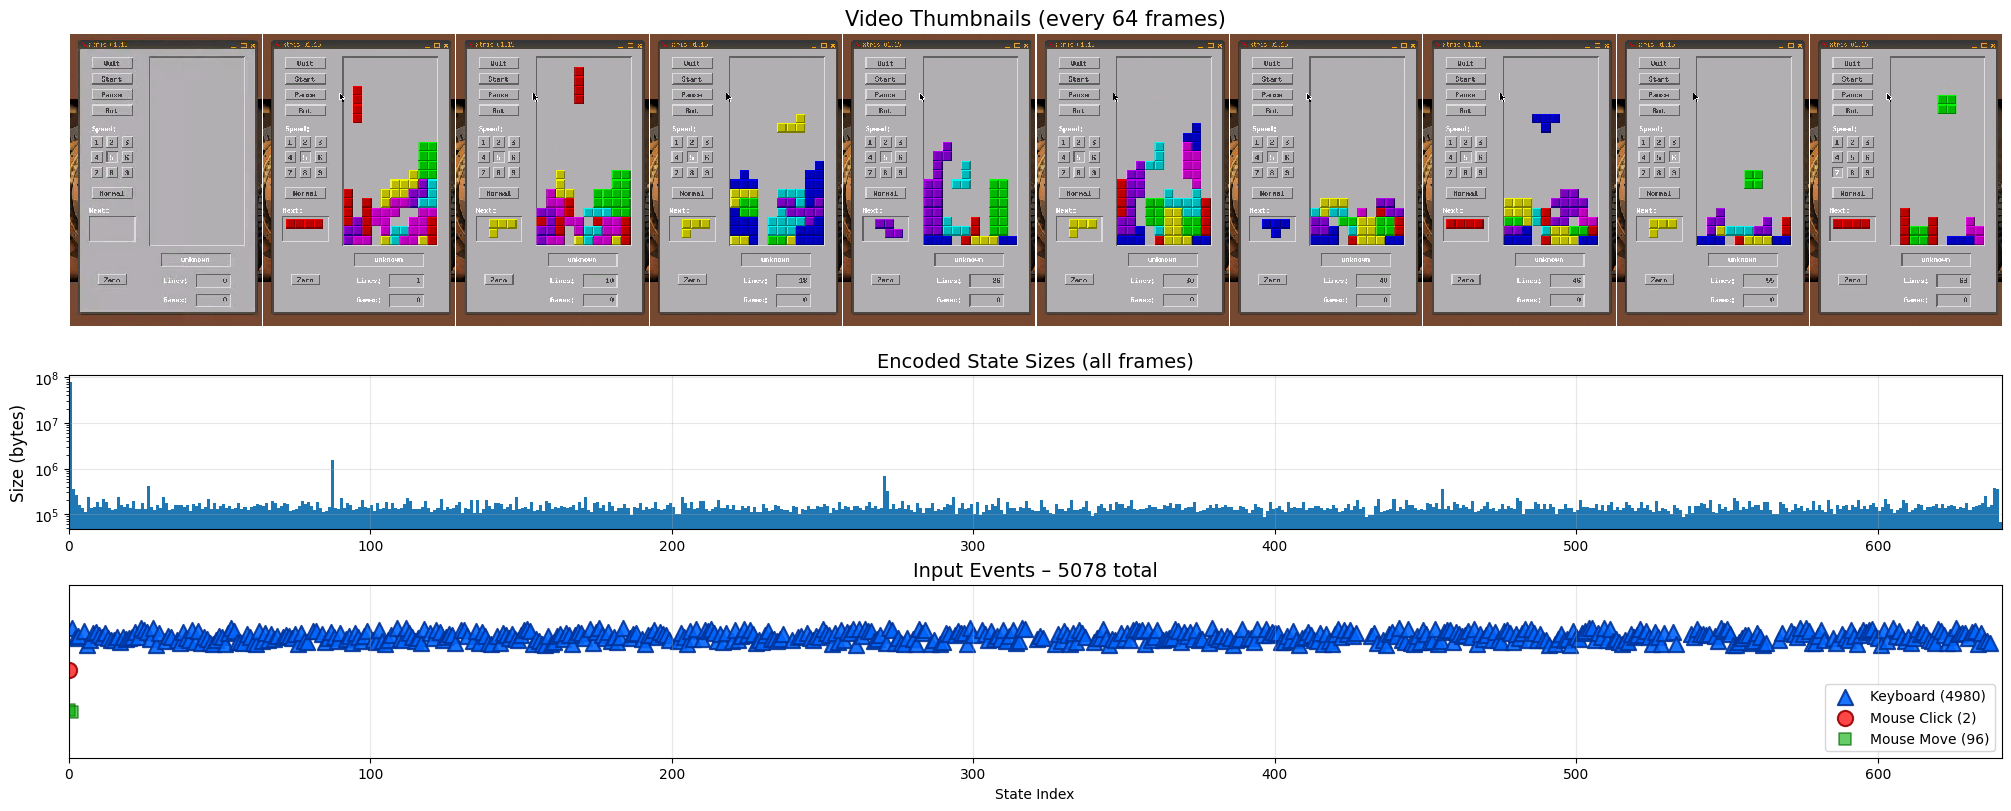

In [301]:
# Create figure with three subplots
fig, (ax1, ax2, ax3) = plt.subplots(
    3, 1,
    figsize=(20, 8),
    constrained_layout=True,
    gridspec_kw={"height_ratios": [1.7, 0.8, 0.9]},
)

# -----------------------------
# 1. Filmstrip
# -----------------------------
if filmstrip is not None:
    # Use 'equal' aspect to prevent stretching - maintains pixel aspect ratio
    ax1.imshow(filmstrip, interpolation='nearest', aspect='equal')
    ax1.axis("off")
    ax1.set_title(f"Video Thumbnails (every {k} frames)", fontsize=15)

# -----------------------------
# 2. State Sizes
# -----------------------------
ax2.bar(np.arange(len(sizes)), sizes, width=1.0, align="edge", edgecolor="none")
ax2.set_xlim(0, len(sizes))
ax2.set_yscale("log")
ax2.set_ylabel("Size (bytes)", fontsize=12)
ax2.set_title("Encoded State Sizes (all frames)", fontsize=14)
ax2.grid(True, alpha=0.3)

# -----------------------------
# 3. Input Events
# -----------------------------
if total_events > 0:
    # Keyboard events
    if keyboard_events:
        kc = Counter(keyboard_events)
        idx = np.array(list(kc.keys()))
        ax3.scatter(idx, jitter(np.full(len(idx), 1.2)),
                    s=120, c="#0066FF", marker="^", alpha=0.9,
                    edgecolors="#003399", linewidths=1.5,
                    label=f"Keyboard ({len(keyboard_events)})")

    # Mouse clicks
    if mouse_click_events:
        cc = Counter(mouse_click_events)
        idx = np.array(list(cc.keys()))
        ax3.scatter(idx, jitter(np.full(len(idx), 1.0)),
                    s=120, c="#FF3333", marker="o", alpha=0.9,
                    edgecolors="#990000", linewidths=1.5,
                    label=f"Mouse Click ({len(mouse_click_events)})")

    # Mouse movement
    if mouse_delta_events:
        dc = Counter(mouse_delta_events)
        idx = np.array(list(dc.keys()))
        ax3.scatter(idx, jitter(np.full(len(idx), 0.8)),
                    s=80, c="#00AA00", marker="s", alpha=0.6,
                    edgecolors="#006600", linewidths=1.2,
                    label=f"Mouse Move ({len(mouse_delta_events)})")

    ax3.set_xlim(0, len(sizes))
    ax3.set_ylim(0.5, 1.5)
    ax3.set_yticks([])
    ax3.set_xlabel("State Index")
    ax3.set_title(f"Input Events – {total_events} total", fontsize=14)
    ax3.legend(loc="lower right")
    ax3.grid(True, alpha=0.3, axis="x")
else:
    ax3.text(0.5, 0.5, "No input events found",
             ha="center", va="center", fontsize=12)
    ax3.set_xlim(0, len(sizes))
    ax3.set_yticks([])
    ax3.set_xlabel("Number of Seconds")

plt.show()